In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.patches as patches
import glob
import matplotlib.cm as cm
import matplotlib as mpl


import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap


from netCDF4 import Dataset
from scipy import stats

from matplotlib.animation import FuncAnimation

import geopandas as gpd
import geocube
from geocube.api.core import make_geocube
## estimate of pressure levels from the hybrid coordinate:
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100

path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/post_processing/'

# Energy budget at the surface

### load data

In [2]:
with xarray.open_dataset(path+'Amazon961x801/energy.ctrl.ensmean.all_tmean.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
with xarray.open_dataset(path+'Amazon961x801/energy.ILgrassland.ensmean.all_tmean.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
                         print('ok')
lats=ds1['XLAT'][0,:,0]
lons=ds1['XLONG'][0,0,:]
lu1=ds1['LU_INDEX'][0,:,:]
lu0=ds0['LU_INDEX'][0,:,:]

Rad_down0 = ds0['SWDNB']-ds0['SWUPB']+ds0['LWDNB']
Rad_down1 = ds1['SWDNB']-ds1['SWUPB']+ds1['LWDNB']
Rad0 = ds0['SWDNB']-ds0['SWUPB']+ds0['LWDNB']-ds0['LWUPB']  ## net radiation into the surface
Rad1 = ds1['SWDNB']-ds1['SWUPB']+ds1['LWDNB']-ds1['LWUPB']  ## net radiation into the surface
Rnet0 = ds0['HFX']+ds0['LH']
Rnet1 = ds1['HFX']+ds1['LH']
Rsoil0 = Rad0 - Rnet0
Rsoil1 = Rad1 - Rnet1

ok
ok


### load the Indigenous lands information for use in plotting

In [3]:
directory = '/ocean/projects/ees210014p/xjliu/DATA/landuse/'
shapefile = 'Raisg/Tis_2020/Tis_TerritoriosIndigenas.shp'  
IL1 = gpd.read_file(directory+shapefile) # read into a GeoDataFrame
IL_big = IL1[IL1.area_sig_h>=1.6e5]  # select only the big domain, domain has more than 10 grids along x and y.
## rasterize data
IL_big['value']=1
IL1['value']=1
out_grid = make_geocube(IL_big,resolution=(0.04,-0.04),measurements=['value'],fill=-9999)
da_grib = xarray.where(out_grid.value<-1999.0, np.nan, out_grid.value)
IL_sel = da_grib.sel(y=lats,x=lons,method='nearest')
IL_sel.shape

### dif_lu will be used to indicate regions of deforestation
dif_lu = lu1-lu0
dif_lu = dif_lu.where(IL_sel==1,0)  ## use IL_sel to select only the big domain
dif_lu = dif_lu.where(dif_lu==8,0)  ## only domain where forests are changed to grassland will be plotted.

/ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
Rad0 = ds0['SWDNB']-ds0['SWUPB']+ds0['LWDNB']-ds0['LWUPB']
Rad1 = ds1['SWDNB']-ds1['SWUPB']+ds1['LWDNB']-ds1['LWUPB']
Rnet0 = ds0['HFX']+ds0['LH']
Rnet1 = ds1['HFX']+ds1['LH']

Rsoil0 = Rad0 - Rnet0
Rsoil1 = Rad1 - Rnet1

Rground0 = Rad0 - Rnet0
Rground1 = Rad1 - Rnet1

netSW0 = ds0['SWDNB']-ds0['SWUPB'] 
netSW1 = ds1['SWDNB']-ds1['SWUPB'] 

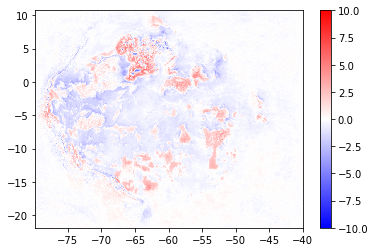

In [12]:
plt.pcolormesh(lons,lats,ds1['LWDNB'][0,:,:]-ds0['LWDNB'][0,:,:],
               cmap='bwr',vmin=-10,vmax=10)
plt.colorbar()

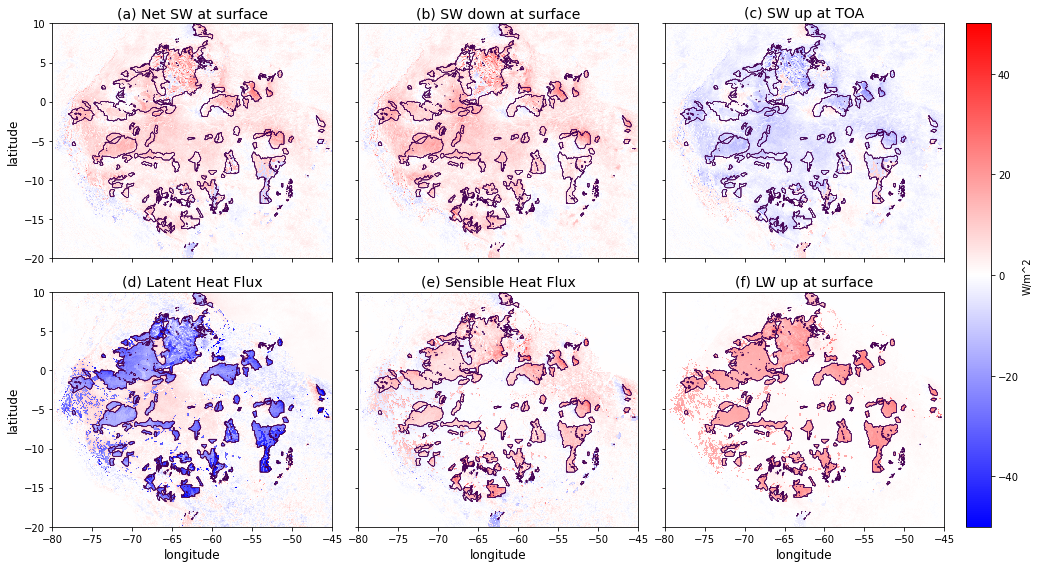

In [18]:
fig,axes = plt.subplots(2,3,figsize=(16,8),sharex=True,sharey=True)
axes = axes.flat 
vmins = [-100,-100,-10,-0.05]
vmaxs = [100,100,10,0.05]

titles = ['(a) Net SW at surface', '(b) SW down at surface', '(c) SW up at TOA',
          '(d) Latent Heat Flux', '(e) Sensible Heat Flux','(f) LW up at surface']
###### Net SWdown at the surface
axes[0].pcolormesh(lons,lats,netSW1[0,:,:] - netSW0[0,:,:],cmap='bwr',
                             vmin=-50,vmax=50)
axes[0].contour(lons,lats,dif_lu,vmin=8,vmax=8,linewidths=0.25) 
#axes[0].set_title('Net SW Down at surface',fontsize=14)


varname = ['bool','SWDNB','SWUPT']
for ii in range(1,3):
    img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]][0,:,:]-ds0[varname[ii]][0,:,:],cmap='bwr',
                             vmin=-50,vmax=50)
    #axes[ii].set_title(varname[ii],fontsize=14)
    axes[ii].contour(lons,lats,dif_lu,vmin=8,vmax=8,linewidths=0.25) 

### Radiation into the atmosphere at surface
varxs=['bool','bool','bool','LH','HFX','LWUPB',]#'SWUPT','LWUPT','LWDNB','LWUPB','LWDNT','LWDNB','LWUPB',
for ii in range(3,6):
    im = axes[ii].pcolormesh(lons,lats,ds1[varxs[ii]][0,:,:] - ds0[varxs[ii]][0,:,:],
                             cmap='bwr',vmin=-50,vmax=50)
    axes[ii].contour(lons,lats,dif_lu,vmin=8,vmax=8,linewidths=0.25) 
    #axes[ii].set_title(varxs[ii],fontsize=14)
    axes[ii].set_xlabel('longitude',fontsize=12)

axes[0].set_ylabel('latitude',fontsize=12)
axes[3].set_ylabel('latitude',fontsize=12)

for ii in range(2):
    axes[ii].set_xlim([-80,-45])
    axes[ii].set_ylim([-20,10])
    
for ii in range(6):
    axes[ii].set_title(titles[ii],fontsize=14)
    
plt.tight_layout()
fig.colorbar(im,ax=axes[:6],orientation='vertical',label='W/m^2',pad=0.02)


#plt.savefig('fig.png',bbox_inches='tight')

## Bar plot of area-averaged energy inside and outside of ILs.

In [38]:
dif_energy_IL=pd.DataFrame()
dif_energy_out=pd.DataFrame()

for var in ['SWDNB','SWUPB','LWDNB','LH','HFX','LWUPB']:
    energy0 = ds0[var][0,:,:]
    energy0_IL = energy0.where(dif_lu==8,np.nan)
    energy0_out = energy0.where(dif_lu==0,np.nan)
    energy0_IL_areamean = energy0_IL.mean(('south_north','west_east'))
    energy0_out_areamean = energy0_out.mean(('south_north','west_east'))

    energy1 = ds1[var][0,:,:]
    energy1_IL = energy1.where(dif_lu==8,np.nan)
    energy1_out = energy1.where(dif_lu==0,np.nan)
    energy1_IL_areamean = energy1_IL.mean(('south_north','west_east'))
    energy1_out_areamean = energy1_out.mean(('south_north','west_east'))
    
    dif_energy_IL.loc[0,var] = energy1_IL_areamean.values - energy0_IL_areamean.values
    dif_energy_out.loc[0,var] = energy1_out_areamean.values - energy0_out_areamean.values
    #print(energy0_IL_areamean.values)
    #print(energy1_IL_areamean.values)
dif_energy_IL

SWDNB     SWUPB     LWDNB       LH        HFX      LWUPB
0  8.890213  2.267838  0.960938 -25.5793  11.361061  17.276581

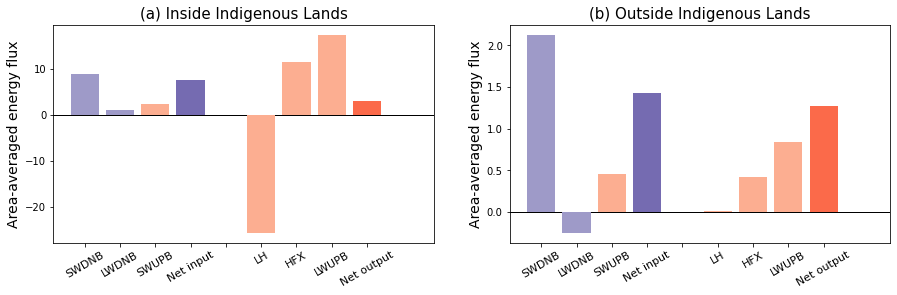

In [90]:
fig,axes = plt.subplots(1,2,figsize=(15,4),sharex=True)
axes = axes.flat

netinput_IL = dif_energy_IL.loc[0,['SWDNB','LWDNB']].values.sum() - dif_energy_IL.loc[0,['SWUPB']].values
netinput_out = dif_energy_out.loc[0,['SWDNB','LWDNB']].values.sum() - dif_energy_out.loc[0,['SWUPB']].values

axes[0].bar(range(10),np.zeros(10))  #claim the space
axes[1].bar(range(10),np.zeros(10))

axes[0].bar(range(2),dif_energy_IL.loc[0,['SWDNB','LWDNB']].values,color=['#9e9ac8'])
axes[0].bar(2,dif_energy_IL.loc[0,['SWUPB']].values,color=['#fcae91'])
axes[0].bar(3,netinput_IL,color=['#756bb1'])
axes[0].bar(range(5,8),dif_energy_IL.loc[0,['LH','HFX','LWUPB']].values,color=['#fcae91'])
axes[0].bar(8,dif_energy_IL.loc[0,['LH','HFX','LWUPB']].values.sum(),color=['#fb6a4a'])

axes[1].bar(range(2),dif_energy_out.loc[0,['SWDNB','LWDNB']].values,color=['#9e9ac8'])
axes[1].bar(2,dif_energy_out.loc[0,['SWUPB']].values,color=['#fcae91'])
axes[1].bar(3,netinput_out,color=['#756bb1'])
axes[1].bar(range(5,8),dif_energy_out.loc[0,['LH','HFX','LWUPB']].values,color=['#fcae91'])
axes[1].bar(8,dif_energy_out.loc[0,['LH','HFX','LWUPB']].values.sum(),color=['#fb6a4a'])

titles = ['(a) Inside Indigenous Lands', '(b) Outside Indigenous Lands']
for ii in range(2):
    axes[ii].set_xticks(range(9),['SWDNB','LWDNB','SWUPB','Net input','','LH','HFX','LWUPB','Net output'],
                        rotation=30,fontsize=11)
    axes[ii].set_ylabel('Area-averaged energy flux',fontsize=14)
    axes[ii].axhline(y=0, xmin=0, xmax=8, c="k", linewidth=1, zorder=0, linestyle='-')
    axes[ii].set_title(titles[ii],fontsize=15)

### Convert latent heat change to rainfall rate, that's about
#### LH = Lvq = Lv*rou*rain_rate. 
#### Lv = 2.25e6 J/kg.

/tmp/ipykernel_91259/816877648.py:12: UserWarning: The following kwargs were not used by contour: 'linecolors'
  axes[0].contour(lons,lats,lu1-lu0,vmin=8,vmax=8,linewidths=0.25,linecolors='k')
/tmp/ipykernel_91259/816877648.py:13: UserWarning: The following kwargs were not used by contour: 'linecolors'
  axes[1].contour(lons,lats,lu1-lu0,vmin=8,vmax=8,linewidths=0.25,linecolors='k')


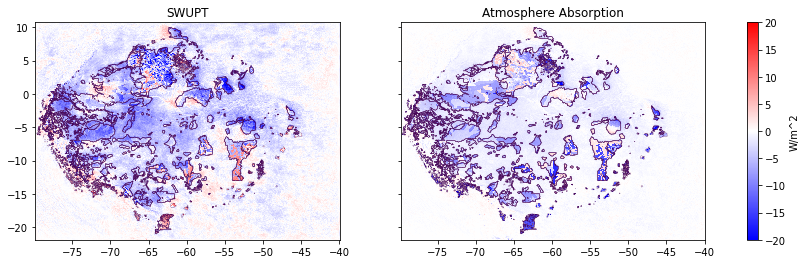

In [211]:
### Absorption by the atmosphere
Rabsorb1 = ds1['SWDNT']-ds1['SWUPT']-ds1['SWDNB']
Rabsorb0 = ds0['SWDNT']-ds0['SWUPT']-ds0['SWDNB']

fig,axes = plt.subplots(1,2,figsize=(15,4),sharex=True,sharey=True)
axes = axes.ravel()  

im = axes[0].pcolormesh(lons,lats,ds1['SWUPT'][0,:,:] - ds0['SWUPT'][0,:,:],
                         cmap='bwr',vmin=-20,vmax=20)
im = axes[1].pcolormesh(lons,lats,Rabsorb1[0,:,:] - Rabsorb0[0,:,:],
                         cmap='bwr',vmin=-20,vmax=20)
axes[0].contour(lons,lats,lu1-lu0,vmin=8,vmax=8,linewidths=0.25,linecolors='k')
axes[1].contour(lons,lats,lu1-lu0,vmin=8,vmax=8,linewidths=0.25,linecolors='k')

axes[0].set_title('SWUPT')
axes[1].set_title('Atmosphere Absorption')

fig.colorbar(im,ax=axes[:4],orientation='vertical',label='W/m^2')

### For local noon

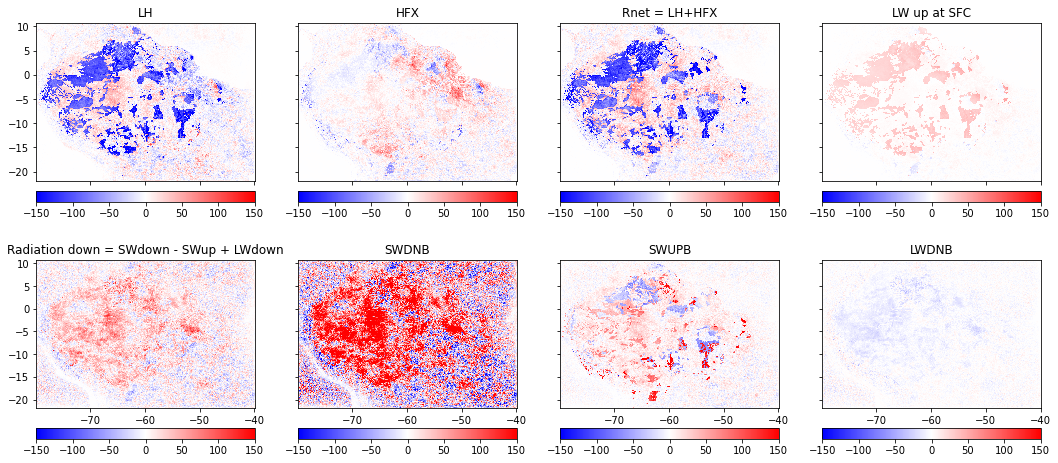

In [61]:
fig,axes = plt.subplots(2,4,figsize=(18,8),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX']
vmins = [-150,-150,-10,-0.05]
vmaxs = [150,150,10,0.05]
for ii in range(2):
    img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]][15,:,:]-ds0[varname[ii]][15,:,:],cmap='bwr',
                             vmin=vmins[ii],vmax=vmaxs[ii])
    fig.colorbar(img,ax=axes[ii],orientation='horizontal',pad=0.05)
    axes[ii].set_title(varname[ii])
    #axes[ii].contour(lons,lats,lu1-lu0,levels=[1]) 
###### Rnet = LH + HFX
img = axes[2].pcolormesh(lons,lats,Rnet1[15,:,:]-Rnet0[15,:,:],cmap='bwr',
                             vmin=-150,vmax=150)
fig.colorbar(img,ax=axes[2],orientation='horizontal',pad=0.05)
axes[2].set_title('Rnet = LH+HFX')

###### LW up at the surface
img = axes[3].pcolormesh(lons,lats,ds1['LWUPB'][15,:,:]-ds0['LWUPB'][15,:,:],cmap='bwr',
                             vmin=-150,vmax=150)
fig.colorbar(img,ax=axes[3],orientation='horizontal',pad=0.05)
axes[3].set_title('LW up at SFC')


### Net radiation at surface
varxs=['SWDNB','SWUPB','LWDNB',]#'SWUPT','LWUPT','LWDNB','LWUPB','LWDNT','LWDNB','LWUPB',
vmins = [-50,-50,-50,-50,-150,-50]
vmaxs = [50,50,50,50,150,50]

img = axes[4].pcolormesh(lons,lats,Rad_down1[15,:,:]- Rad_down0[15,:,:],cmap='bwr',
                             vmin=-150,vmax=150)
#axes[0].contour(lons,lats,lu1-lu0,levels=[1])     
fig.colorbar(img,ax=axes[4],orientation='horizontal',pad=0.1)
axes[4].set_title('Radiation down = SWdown - SWup + LWdown')

for ii in range(0,3):
    im = axes[ii+5].pcolormesh(lons,lats,ds1[varxs[ii]][15,:,:] - ds0[varxs[ii]][15,:,:],
                             cmap='bwr',vmin=vmins[ii],vmax=vmaxs[ii])
    #axes[ii+1].contour(lons,lats,lu1-lu0,levels=[1])
    axes[ii+5].set_title(varxs[ii])
    fig.colorbar(img,ax=axes[ii+5],orientation='horizontal',pad=0.1)

#fig.colorbar(im,ax=axes[:4],orientation='horizontal',label='W/m^2')

## Decompose SW down at surface to SW up at TOA and absorption
#### Increase in SW down at the botoom is mainly due to decrease in reflected SW at TOA and also due to decrease in atmosphere absorption

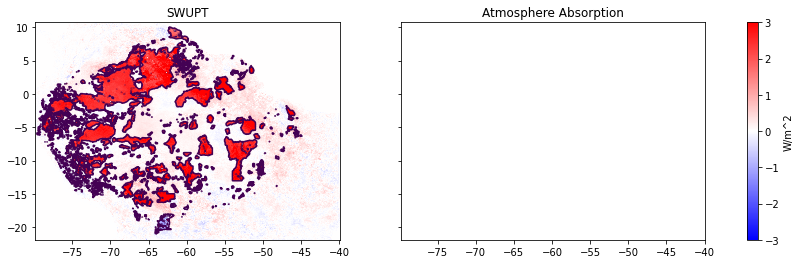

In [54]:
fig,axes = plt.subplots(1,2,figsize=(15,4),sharex=True,sharey=True)
axes = axes.ravel()  

im = axes[0].pcolormesh(lons,lats,ds1['TSK'][0,:,:] - ds0['TSK'][0,:,:],
                         cmap='bwr',vmin=-3,vmax=3)

axes[0].contour(lons,lats,lu1-lu0,levels=[1])
#axes[1].contour(lons,lats,lu1-lu0,levels=[1])

axes[0].set_title('SWUPT')
axes[1].set_title('Atmosphere Absorption')

fig.colorbar(im,ax=axes[:4],orientation='vertical',label='W/m^2')


# Do we need a bar plot to summarize the above?

# The decrease in reflected SW at TOA suggests fewer low clouds. 
# The decrease in absorption suggested drier atmosphere. 

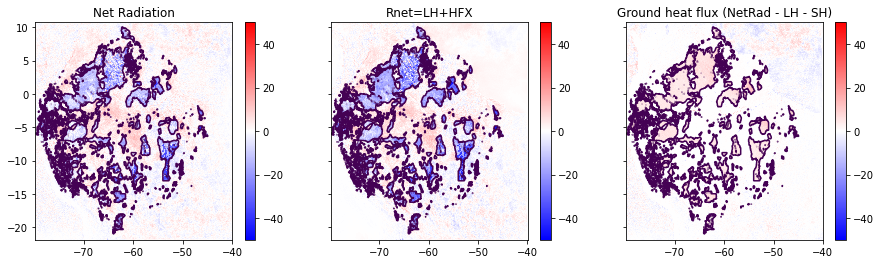

In [6]:
dif_Rnet = Rnet1.mean(axis=0) - Rnet0.mean(axis=0)
dif_Rad = Rad1.mean(axis=0) - Rad0.mean(axis=0)
dif_Rsoil = dif_Rad - dif_Rnet

fig,axes = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)
axes = axes.ravel()  

im = axes[0].pcolormesh(lons,lats,dif_Rad,cmap='bwr',vmin=-50,vmax=50)
fig.colorbar(im,ax=axes[0])

im = axes[1].pcolormesh(lons,lats,dif_Rnet,cmap='bwr',vmin=-50,vmax=50)
fig.colorbar(im,ax=axes[1])

im = axes[2].pcolormesh(lons,lats,dif_Rsoil,cmap='bwr',vmin=-50,vmax=50)
fig.colorbar(im,ax=axes[2])

titles=['Net Radiation','Rnet=LH+HFX','Ground heat flux (NetRad - LH - SH)']
for ii in range(3):
    axes[ii].set_title(titles[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1])

## Why is there reduction in SWUPT? Changes in clouds as a response to deforestation? Check clouds and humidity. 

## Show SWUPT of every month and every member. 

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


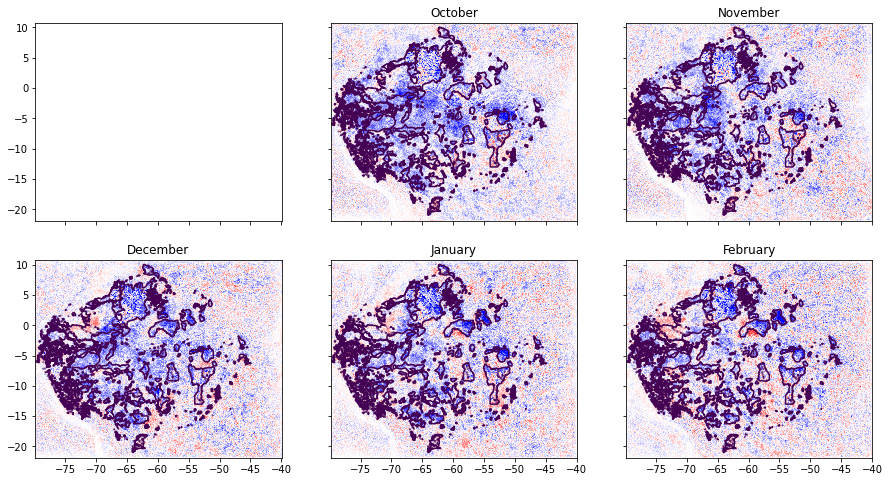

In [6]:
months=['September','October','November','December','January','February']

fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
axes = axes.ravel()  

for ii in range(1,6):
    with xarray.open_dataset(path+'Amazon961x801/energy.'+months[ii]+'.ensmean.ctrl.nc',decode_times=False,
                             mask_and_scale='True') as ds0:
        print('ok')
    with xarray.open_dataset(path+'Amazon961x801/energy.'+months[ii]+'.ensmean.ILgrassland.nc',decode_times=False,
                             mask_and_scale='True') as ds1:
                             print('ok')

    im = axes[ii].pcolormesh(lons,lats,ds1['SWUPT'][15,:,:] - ds0['SWUPT'][15,:,:],
                             cmap='bwr',vmin=-100,vmax=100)
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1])
    axes[ii].set_title(months[ii])

## Show SWUPT of every member. 

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


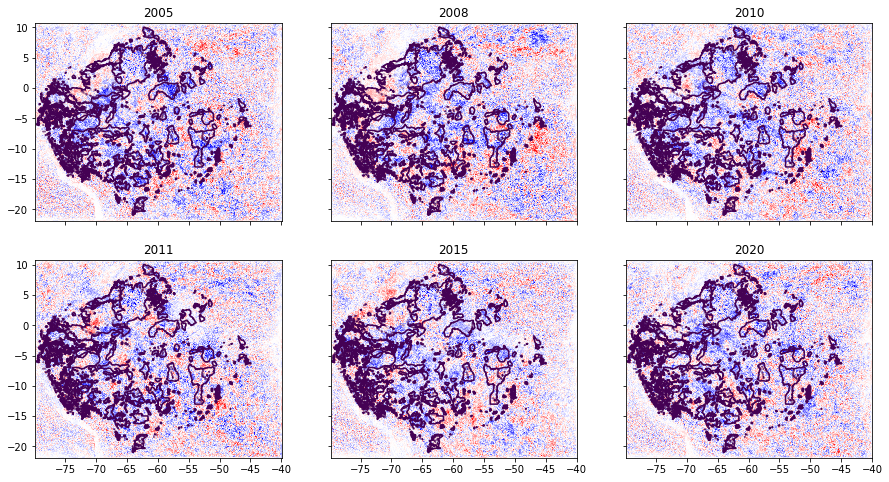

In [12]:
years=['2005','2008','2010','2011','2015','2020']
months=['September','October','November','December','January','February']

fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
axes = axes.ravel()  

vmins = [-50,-50,-50,-50,-150,-50]
vmaxs = [50,50,50,50,150,50]

for ii in range(0,6):
    with xarray.open_dataset(path+'Amazon961x801/energy.'+years[ii]+'12.ctrl.nc',decode_times=False,
                             mask_and_scale='True') as ds0:
        print('ok')
    with xarray.open_dataset(path+'Amazon961x801/energy.'+years[ii]+'12.ILgrassland.nc',decode_times=False,
                             mask_and_scale='True') as ds1:
                             print('ok')

    im = axes[ii].pcolormesh(lons,lats,ds1['SWUPT'][15,:,:] - ds0['SWUPT'][15,:,:],
                             cmap='bwr',vmin=-190,vmax=190)
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1])
    axes[ii].set_title(years[ii])

## Plot the winds

<ipython-input-22-6e6bd5d53a48>:7: UserWarning: The following kwargs were not used by contour: 'scale_units'
  plt.contour(lons,lats,lu1-lu0,levels=[1],scale_units='inches')


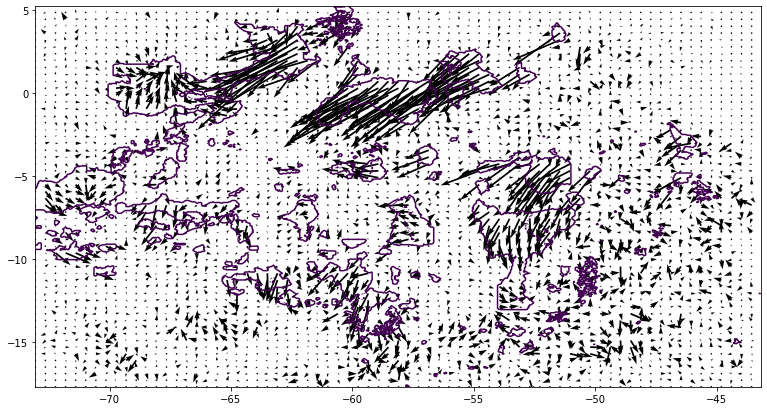

In [22]:
plt.figure(figsize=(13,7))
u10 = ds1['U10']-ds0['U10']
v10 = ds1['V10']-ds0['V10']
plt.quiver(lons[::10], lats[::10],
           u10[0,::10, ::10], v10[0,::10, ::10],
           cmap='jet')
plt.contour(lons,lats,lu1-lu0,levels=[1],scale_units='inches')


## 4. Relate 3 to clouds, surface temperature, and surface humidity etc. 

## Soil moisture

In [9]:
with xarray.open_dataset(path+'SMOIS.201409_201412.ILave.ctrl.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
with xarray.open_dataset(path+'SMOIS.201409_201412.ILave.ILgrassland.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
smois0_areaave = ds0['SMOIS']
smois1_areaave = ds1['SMOIS']

ok
ok


Text(0, 0.5, 'Soil Moisture [m3/m3]')

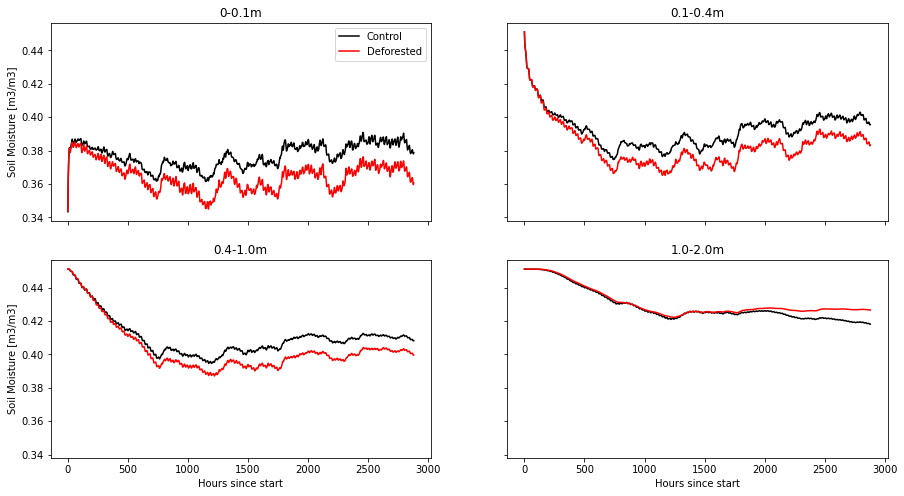

In [11]:
fig,axes = plt.subplots(2,2,figsize=(15,8),sharex=True,sharey=True)
axes = axes.ravel()  
titles=['0-0.1m','0.1-0.4m','0.4-1.0m','1.0-2.0m']
for ii in range(4):
    axes[ii].plot(smois0_areaave[:,ii],'k',label='Control')
    axes[ii].plot(smois1_areaave[:,ii],'r',label='Deforested')
    axes[ii].set_title(titles[ii])
axes[0].legend()
axes[2].set_xlabel('Hours since start')
axes[3].set_xlabel('Hours since start')
axes[0].set_ylabel('Soil Moisture [m3/m3]')
axes[2].set_ylabel('Soil Moisture [m3/m3]')

### Soil moisture

ok


<ipython-input-83-b578299b01ef>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes[ii].pcolormesh(lons,lats,ds1['SMOIS'][600+ii*5,0,:,:],cmap='coolwarm',vmin=-0.1,vmax=0.1


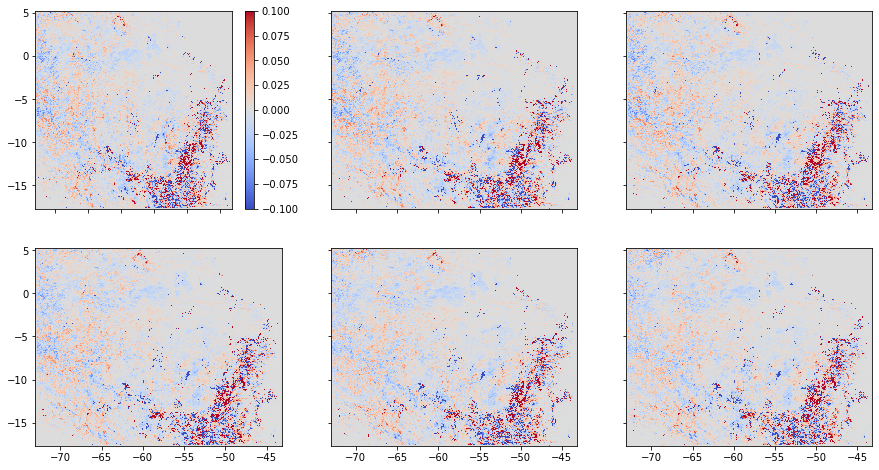

In [83]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'

with xarray.open_dataset(path+'Amazon_NoahMP_dveg9_201407_ILgrassland/dif_LAND.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['SMOIS']


for ii in range(6):
    img = axes[ii].pcolormesh(lons,lats,ds1['SMOIS'][600+ii*5,0,:,:],cmap='coolwarm',vmin=-0.1,vmax=0.1
                         )
fig.colorbar(img,ax=axes[0])
#axes[ii].contour(lons,lats,lu1,levels=[5])

In [ ]:
### TSK for both noon and night
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
img = axes[0].contourf(lons,lats,ds0['TSK'].mean('Time')-273.15,cmap='rainbow',
                             levels=np.arange(20,51,1),extend='both')
fig.colorbar(img,ax=axes[0])
axes[0].set_title('TSK at local noon')
### local night
img = axes[1].contourf(lons,lats,ds1['TSK'].mean('Time')-273.15,cmap='rainbow',
                             levels=np.arange(20,31,1),extend='both')
fig.colorbar(img,ax=axes[1])
axes[ii].set_title('TSK at local night')

ok


Text(0.5, 1.0, 'TSK at local night')

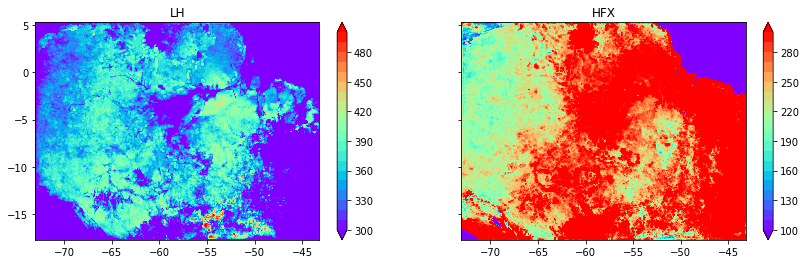

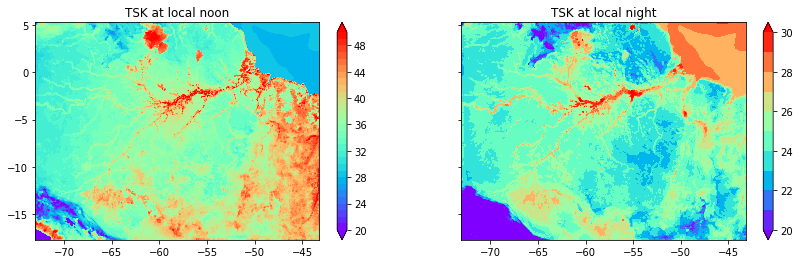

In [17]:
### Default NOAH_MP
with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.2015.obs.NoahMP.multidaymean.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','TSK','ALBEDO']
levs=[np.arange(300,501,10),np.arange(100,301,10),np.arange(20,51,1)]

for ii in range(2):
    img = axes[ii].contourf(lons,lats,ds0[varname[ii]][15,:,:],cmap='rainbow',
                             levels=levs[ii],extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    #axes[ii].contour(lons,lats,lu1,levels=[5])

### TSK for both noon and night
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
img = axes[0].contourf(lons,lats,ds0['TSK'][15,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,51,1),extend='both')
fig.colorbar(img,ax=axes[0])
axes[0].set_title('TSK at local noon')
### local night
img = axes[1].contourf(lons,lats,ds0['TSK'][5,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,31,1),extend='both')
fig.colorbar(img,ax=axes[1])
axes[ii].set_title('TSK at local night')    

ok


Text(0.5, 1.0, 'TSK at local night')

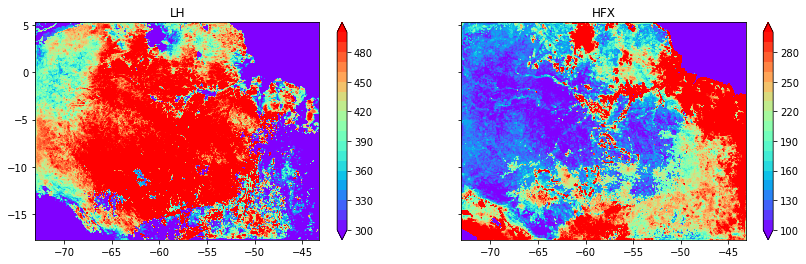

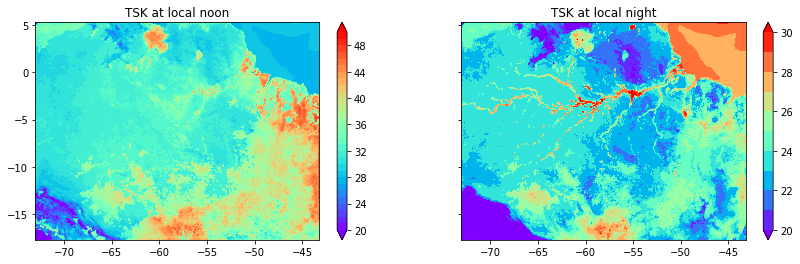

In [18]:
#### CLM4 
with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','TSK','ALBEDO']
levs=[np.arange(300,501,10),np.arange(100,301,10),np.arange(20,51,1)]

for ii in range(2):
    img = axes[ii].contourf(lons,lats,ds0[varname[ii]][15,:,:],cmap='rainbow',
                             levels=levs[ii],extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    #axes[ii].contour(lons,lats,lu1,levels=[5])

### TSK for both noon and night
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
img = axes[0].contourf(lons,lats,ds0['TSK'][15,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,51,1),extend='both')
fig.colorbar(img,ax=axes[0])
axes[0].set_title('TSK at local noon')
### local night
img = axes[1].contourf(lons,lats,ds0['TSK'][5,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,31,1),extend='both')
fig.colorbar(img,ax=axes[1])
axes[ii].set_title('TSK at local night')    

ok
ok


<ipython-input-6-2c93235d98cf>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]].mean('Time')-ds0[varname[ii]].mean('Time'),cmap='bwr',
<ipython-input-6-2c93235d98cf>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]].mean('Time')-ds0[varname[ii]].mean('Time'),cmap='bwr',
<ipython-input-6-2c93235d98cf>:21: MatplotlibDeprecationWarning: shading='flat' when

Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

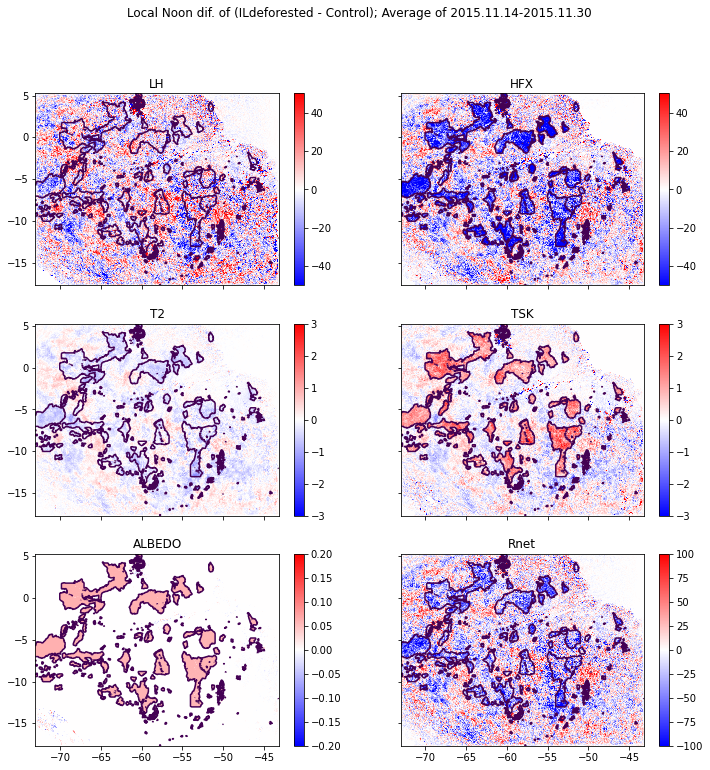

In [6]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
#with xarray.open_dataset(path+'Amazon/energyflux_d01_2015-11-01_15:00:00',decode_times=False,
with xarray.open_dataset(path+'Amazon_NoahMP_dveg9/energyflux_d01_201511_15UTC.obs.multidaymean.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

#with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
 #                        mask_and_scale='True') as ds0:
with xarray.open_dataset(path+'Amazon_NoahMP_dveg9_ILgrassland/energyflux_d01_201511_15UTC.ILgrassland.multidaymean.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
                         print('ok')
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','T2','TSK','ALBEDO']

vmins=[-50,-50,-3,-3,-0.2,-100]
vmaxs=[50,50,3,3,0.2,100]
cmaps=['PiYG','PiYG','bwr','coolwarm','bwr','PiYG']
for ii in range(5):
    img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]].mean('Time')-ds0[varname[ii]].mean('Time'),cmap='bwr',
                             vmin=vmins[ii],vmax=vmaxs[ii])
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    
## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']

img = axes[5].pcolormesh(lons,lats,Rnet1.mean('Time')-Rnet0.mean('Time'),vmin=vmins[5],vmax=vmaxs[5],
                       cmap='bwr')

fig.colorbar(img,ax=axes[5])
axes[5].set_title('Rnet')
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])    

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

## Diurnal cycle

In [53]:
dif = ds1[varname[ii]] - ds0[varname[ii]]
dif_lu = lu1-lu0
dif_forests = dif.where(dif_lu>0)
diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
diurnal_west = dif_forests[0,100:,:200].mean(('south_north','west_east'))
#plt.contourf(dif_forests)


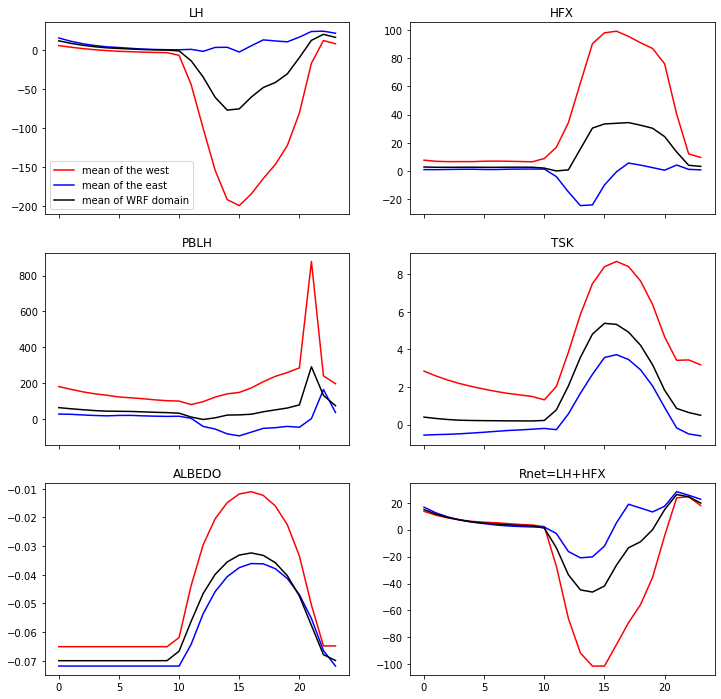

In [70]:
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True)
axes = axes.ravel()  
varname = ['LH','HFX','PBLH','TSK','ALBEDO','Rnet=LH+HFX']
for ii in range(5):
    dif = ds1[varname[ii]] - ds0[varname[ii]]
    dif_lu = lu1-lu0
    dif_forests = dif.where(dif_lu>0)
    diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
    diurnal_west = dif_forests[:,100:,:200].mean(('south_north','west_east'))
    diurnal_all = dif_forests.mean(('south_north','west_east'))

    
    axes[ii].plot(range(24),diurnal_north,'-r',label='mean of the west')
    axes[ii].plot(range(24),diurnal_west,'-b',label='mean of the east')
    axes[ii].plot(range(24),diurnal_all,'-k',label='mean of WRF domain')

    axes[ii].set_title(varname[ii])
    
axes[0].legend()
   
## plot Rnet
dif_Rnet = ds1['LH'] + ds1['HFX'] - (ds0['LH'] + ds0['HFX'])
dif_forests = dif_Rnet.where(dif_lu>0)
diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
diurnal_west = dif_forests[:,100:,:200].mean(('south_north','west_east'))
diurnal_all = dif_forests.mean(('south_north','west_east'))
axes[5].plot(range(24),diurnal_north,'-r')
axes[5].plot(range(24),diurnal_west,'-b')
axes[5].plot(range(24),diurnal_all,'-k')
axes[5].set_title(varname[5])

